# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [1]:

# import os
# import string
#
# # 定义源目录路径
# source_dir = "EnglishHnd/EnglishHnd/English/Hnd/Img"
#
# # 生成目标文件夹名称列表
# target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]
#
# # 获取源目录下的所有文件夹名称
# source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])
#
# # 确保源文件夹数量与目标文件夹数量一致
# if len(source_folders) != len(target_folders):
#     raise ValueError("源文件夹数量与目标文件夹数量不一致")
#
# # 重命名文件夹
# for source_folder, target_folder in zip(source_folders, target_folders):
#     source_path = os.path.join(source_dir, source_folder)
#     target_path = os.path.join(source_dir, target_folder)
#
#     try:
#         os.rename(source_path, target_path)
#         print(f"重命名: {source_path} -> {target_path}")
#     except FileExistsError:
#         print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
#     except Exception as e:
#         print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")


### 划分训练集和测试集

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
#数据增强
from albumentations.pytorch import ToTensorV2
import albumentations as A
from myCnn.baseline.LeNet5 import LeNet5
from myCnn.train_model import train_model
from myCnn.utils import split_dataset
from myCnn.baseline.resnet18 import resnet18
from myCnn.baseline.mobilenet_v2 import mobilenet_v2
from myCnn.baseline.svm_model import train_svm, flatten_images
from myCnn.CBAMNet_Lite import CharsLightAttentionNet
from myCnn.evaluate_model import evaluate_model
from myCnn.MobileNetV2_SE import MobileNetV2_SE
EPOCH = 100
BATCH_SIZE = 128
LR = 1e-4

In [3]:
# # 定义数据预处理变换
# transform = T.Compose([
#     T.Resize((64, 64)),
#     T.Grayscale(num_output_channels=3),
#     T.RandomRotation(15),  # 数据增强：随机旋转
#     T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
#     T.ToTensor(),
#     # 如果需要标准化，可以取消注释以下行
#     T.Normalize([0.5], [0.5])
# ])
class AlbumentationsTransform:
    def __init__(self):
        self.transform=A.Compose([
            A.Resize(28, 28),
            A.Rotate(limit=15, p=0.5),
            A.Affine(translate_percent=(0.1,0.1),p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,),std=(0.5,)),
            ToTensorV2()
        ])
    def __call__(self, img):
        img=np.array(img)
        # img = np.array(img.convert('L'))
        return self.transform(image=img)['image']

transform=AlbumentationsTransform()


训练集大小: 32900
验证集大小: 7050
测试集大小: 7050
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a_': 36, 'b_': 37, 'd_': 38, 'e_': 39, 'f_': 40, 'g_': 41, 'h_': 42, 'n_': 43, 'q_': 44, 'r_': 45, 't_': 46}


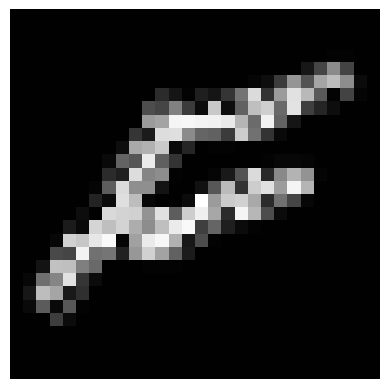

In [4]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="emnist_png_balanced",
    # root_dir="EnglishImg/EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)
print(full_dataset.class_to_idx)
# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 28, 28]
plt.imshow(a)
plt.axis('off')
plt.show()


# 获取类别数量
label_num = len(full_dataset.class_to_idx)

In [5]:

# # 获取展平后的训练集和验证集
# X_train, y_train = flatten_images(train_loader)
# X_val, y_val = flatten_images(val_loader)

In [6]:

# # 训练SVM模型
# svm_clf, train_acc, val_acc = train_svm(X_train, y_train, X_val, y_val)

In [13]:

# 初始化模型
cnn = MobileNetV2_SE(num_classes=label_num)
# 加载最好的权重模型
# cnn.load_state_dict(torch.load('myCnn/best_model.pth'))

print(cnn)

# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)  # 将模型迁移到 GPU

# 假设使用cpu
# cnn.to('cpu')

# 创建优化器
optimizer = torch.optim.AdamW(cnn.parameters(), lr=3e-4, weight_decay=0.05)

# 创建学习率调度器（Cosine退火）
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCH,  # 周期长度
    eta_min=1e-5       # 最小学习率
)

# 定义损失函数
loss_func = nn.CrossEntropyLoss()

MobileNetV2_SE(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6()
    (3): InvertedResidualSE(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6()
        (3): SEBlock(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): ReLU()
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4):

In [14]:
# 训练模型
cnn = train_model(cnn, train_loader, val_loader, loss_func, optimizer, scheduler=scheduler,num_epochs=EPOCH)



2025-04-20 15:12:30,385 - INFO - Using device: cuda
2025-04-20 15:12:30,390 - INFO - Starting training...
2025-04-20 15:12:51,949 - INFO - Epoch [1/100], Train Loss: 3.2953, Train Top-1: 12.88%, Train Top-3: 28.64%, | Val Loss: 2.4537, Val Top-1: 28.74%, Val Top-3: 56.62%
2025-04-20 15:13:13,499 - INFO - Epoch [2/100], Train Loss: 1.8792, Train Top-1: 42.92%, Train Top-3: 71.64%, | Val Loss: 1.4471, Val Top-1: 54.62%, Val Top-3: 82.64%
2025-04-20 15:13:35,857 - INFO - Epoch [3/100], Train Loss: 1.2591, Train Top-1: 59.42%, Train Top-3: 86.02%, | Val Loss: 1.1093, Val Top-1: 64.65%, Val Top-3: 89.45%
2025-04-20 15:13:56,356 - INFO - Epoch [4/100], Train Loss: 0.9819, Train Top-1: 68.02%, Train Top-3: 91.05%, | Val Loss: 0.9288, Val Top-1: 69.50%, Val Top-3: 91.80%
2025-04-20 15:14:17,269 - INFO - Epoch [5/100], Train Loss: 0.8561, Train Top-1: 71.82%, Train Top-3: 92.92%, | Val Loss: 0.8077, Val Top-1: 73.67%, Val Top-3: 93.25%
2025-04-20 15:14:37,630 - INFO - Epoch [6/100], Train Loss:

In [ ]:
import base64
import os
import json
from concurrent.futures import ThreadPoolExecutor
from openai import OpenAI

# 初始化客户端
client = OpenAI(
    api_key="api",  # 替换为您的ModelScope SDK Token
    base_url="https://api-inference.modelscope.cn/v1"
)

def analyze_image(image_path):
    """单张图片分析函数"""
    try:
        with open(image_path, "rb") as file:
            encoded_file = base64.b64encode(file.read()).decode("utf-8")

        response = client.chat.completions.create(
            model="Qwen/Qwen2.5-VL-72B-Instruct",
            messages=[
                {
                    "role": "system",
                    "content": [{"type": "text", "text": "You are a helpful and harmless assistant."}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/png;base64,{encoded_file}"}
                        },
                        {
                            "type": "text",
                            "text": """（保持原prompt内容不变）"""
                        }
                    ],
                }
            ],
            stream=False  # 关闭流式输出以提高并发效率
        )

        # 提取分析结果
        result = response.choices[0].message.content
        return {
            "image_path": image_path,
            "result": result.strip("---\n").strip()  # 清理格式标记
        }
    except Exception as e:
        print(f"处理 {image_path} 时出错: {str(e)}")
        return {"image_path": image_path, "error": str(e)}

def batch_process(folder_path, output_file="results.json", max_workers=3):
    """批量处理文件夹内所有图片"""
    # 获取所有图片文件（支持jpg/png）
    image_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.png'))
    ]

    print(f"发现 {len(image_files)} 张待处理图片")

    # 并发处理（3线程）
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(analyze_image, img) for img in image_files]
        for future in futures:
            results.append(future.result())

    # 保存结果
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"结果已保存至 {output_file}")

# 使用示例
if __name__ == "__main__":
    batch_process("train/高风险")  # 处理该文件夹内所有图片

In [9]:
# 推理

top1_acc, top3_acc, inference_speed = evaluate_model(cnn, test_loader, device)
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Inference Speed: {inference_speed * 1000:.4f} ms per sample")

Top-1 Accuracy: 86.8227
Top-3 Accuracy: 98.7234
Inference Speed: 0.0448 ms per sample


In [10]:
# 将推理得出的数据(正确率、速度)保存
with open('results/results.txt', 'w') as f:
    f.write(f"Top-1 Accuracy: {top1_acc:.4f}\n")
    f.write(f"Top-3 Accuracy: {top3_acc:.4f}\n")
    f.write(f"Inference Speed: {inference_speed * 1000:.4f} ms per sample\n")